### Life Expectancy Linear Regression
- Preprocessing
    - Outlier processing
    - Missing data preprocessing
    - Scaler<br><br>
- Model
    - Linear Regression
    - Decision Tree Regressor
    - XGBoost Regressor   
    - RandomForest Regressor<br><br>
    
- Cross Validation
    - KFold<br><br>
    
- OLS
    - RMSE
    - R-squared
    - P<br><br>
- Feature Extraction
    - PCA
    - KMeans

In [13]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler 
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
import statsmodels.api as sm
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from xgboost import XGBRegressor
from xgboost import plot_importance

In [14]:
# preprocessing
original = pd.read_csv("../datas/life_expectancy_data_fillna.csv")

def add_feature(original, filename=None):
    path = "../datas/worldbank_"
    original.columns = [cols.upper() for cols in original.columns.tolist()]
    
    if not filename == None:
        df = pd.read_csv(f"{path}{filename}.csv").groupby('Country Code').mean()
        df.drop(columns=['2016', '2017','2018','2019','2020'], axis=1, inplace=True)
        col_name = filename.upper()
        original[col_name] = [df.loc[original['COUNTRYCODE'][i]][str(original['YEAR'][i])] 
                              for i in range(len(original))]

    return original

In [15]:
def preprocessing(data):
    # GDP per capita 데이터 추가
    data = add_feature(data, "gdppercap")

    # Nan값 GDP/POP으로 대체
    data["GDPPERCAP"].fillna(data["GDP"] / data["POPULATION"], inplace=True)
    data.columns = [cols.upper() for cols in original.columns.tolist()]
    
    if 'STATUS' in data.columns.tolist():
        data = pd.get_dummies(original, columns=['STATUS'], drop_first=True)   
    
    return data

In [16]:
# corr
def get_top_features(data, drop_n=None):
    if drop_n is None:
        drop_n = len(data.columns)
        
    # LIFE_EXPECTANCY와 대한 나머지 feature들의 상관관계
    corr_matrix = data.drop(['COUNTRYCODE','ISO3166','COUNTRY','YEAR', 'REGION','INCOMEGROUP'], axis=1).corr()
    corr_matrix['LIFE_EXPECTANCY'].sort_values(ascending=False) 
    
    # LIFE_EXPECTANCY와 높은 상관관계를 가지는 피처 순 정렬
    top_corr = abs(corr_matrix['LIFE_EXPECTANCY']).sort_values(ascending=False)[1:drop_n]
    top_features = top_corr.index.tolist()
    
    return top_features

In [17]:
# lower fence, upper fence
def get_fence(data, top_features):
    region = data['REGION'].unique().tolist()
    fence = {}

    for r in region:
        fence[r] = {}

        for i, f in enumerate(top_features):
            q1 = np.percentile(original[data['REGION'] == r][top_features[i]].values, 25)
            q3 = np.percentile(original[data['REGION'] == r][top_features[i]].values, 75)
            iqr = q3 - q1

            upper_fence = ((iqr * 1.5) + q3).round(3)
            lower_fence = (q1 - (iqr * 1.5)).round(3)

            fence[r][f] = [lower_fence, upper_fence]
    
    return fence

In [18]:
# outlier processing
def drop_outlier(data, fence, top_features):
    region = data['REGION'].unique().tolist()
    drop_list, target_idx = [], []

    for r in region:
        target_df = data[data['REGION'] == r]

        for f in top_features:
            drop_idx = target_df[(target_df[f] < fence[r][f][0]) | 
                                 (target_df[f] > fence[r][f][1])].index.tolist()

            drop_list.append(drop_idx)

    # 제거 대상 인덱스
    target_idx = set([idx for lst in drop_list for idx in lst])
    data = data.drop(target_idx, axis=0)
    
    return data

In [54]:
# sortion X, y
def original_sortion_xy(data=None):
    if data is None:
        data = pd.read_csv("../datas/life_expectancy_data_fillna.csv")
        
    data.columns = [cols.upper() for cols in data.columns.tolist()]
    if 'STATUS' in data.columns.tolist():
        original = pd.get_dummies(data, columns=['STATUS'])   
    
    X = original.drop(['COUNTRYCODE','ISO3166','COUNTRY','YEAR','LIFE_EXPECTANCY','REGION','INCOMEGROUP'], axis=1)
    y = original['LIFE_EXPECTANCY']
    
    return X, y

In [21]:
# RandomForest Regressor
def rf_regressor_score(data, count):
    X, y = original_sortion_xy(data)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)

    model = RandomForestRegressor()
    model.fit(X_train, y_train)
   
    model_score = model.score(X_test, y_test)
    model_rmse = np.sqrt(model.score(X_test, y_test)).mean()
    
    return model_score, model_rmse

In [22]:
# cross validation
def cross_validation(X, y, count, n_split=5):
    kfold = KFold(n_splits=n_split, shuffle=True, random_state=13)
    model = RandomForestRegressor()
    cv_score = cross_val_score(model, X, y, cv=kfold)
    
    cv_score = cv_score.mean()
    cv_std = cv_score.std()
    rfcv_rmse_score = np.sqrt(cv_score).mean()
    rfcv_rmse_std = np.sqrt(cv_score).std()
    
    return cv_score, cv_std, rfcv_rmse_score, rfcv_rmse_std

### Preprocessing
- #### outlier processing<br>
    - Target과 상관계수가 높은 Feature 순서대로 누적시키면서 각 Feature에 대한 이상치를 더 많이 제거한다.
    - RandomForest Regressor
        - RMSE
        - R-squared
        - Cross Validation Score

In [25]:
data = preprocessing(original)
top_features = get_top_features(data)
count = len(top_features)
start = 2

eval_df = pd.DataFrame()

for num in range(start, count):

    data = preprocessing(original)
    top_features = get_top_features(data, num)
    fence = get_fence(data, top_features)
    data = drop_outlier(data, fence, top_features)
    X, y = original_sortion_xy(data)
    
    rf_score, rf_rmse = rf_regressor_score(data, num)
    cv_score, cv_std, rfcv_rmse_score, rfcv_rmse_std = cross_validation(X, y, num)
    
    res = {'RF R-squared': rf_score.round(3), 
           'RF RMSE': rf_rmse.round(3), 
           'CV Score': cv_score.round(3), 
           'CV Std': cv_std.round(3), 
           'RF + CV RMSE score': rfcv_rmse_score.round(3), 
           'RF + CV RMSE std': rfcv_rmse_std.round(3)}
    
    eval_df = eval_df.append(res, ignore_index=True)
    
    print('num:', num)
    print('rf_score, rf_rmse, cv_score, cv_std, rfcv_rmse_score, rfcv_rmse_std:', rf_score, rf_rmse, cv_score, cv_std, rfcv_rmse_score, rfcv_rmse_std)

num: 2
rf_score, rf_rmse, cv_score, cv_std, rfcv_rmse_score, rfcv_rmse_std: 0.9733040288589988 0.9865617207549656 0.9701340492061192 0.0 0.984953831002306 0.0
num: 3
rf_score, rf_rmse, cv_score, cv_std, rfcv_rmse_score, rfcv_rmse_std: 0.9729845528503751 0.9863997936183762 0.9701342247491569 0.0 0.9849539201146198 0.0
num: 4
rf_score, rf_rmse, cv_score, cv_std, rfcv_rmse_score, rfcv_rmse_std: 0.9730950618745923 0.9864558083738938 0.9706685197402278 0.0 0.9852251112005965 0.0
num: 5
rf_score, rf_rmse, cv_score, cv_std, rfcv_rmse_score, rfcv_rmse_std: 0.9734809346842062 0.9866513744399317 0.9703963013311887 0.0 0.9850869511526323 0.0
num: 6
rf_score, rf_rmse, cv_score, cv_std, rfcv_rmse_score, rfcv_rmse_std: 0.9728650490342529 0.9863392160074813 0.9707014105223172 0.0 0.9852418030728889 0.0
num: 7
rf_score, rf_rmse, cv_score, cv_std, rfcv_rmse_score, rfcv_rmse_std: 0.9736316604980223 0.9867277539919622 0.9705043813746229 0.0 0.985141807748825 0.0
num: 8
rf_score, rf_rmse, cv_score, cv_std

In [26]:
eval_df = eval_df.sort_values('RF R-squared', ascending=False)
eval_df

,CV Score,CV Std,RF + CV RMSE score,RF + CV RMSE std,RF R-squared,RF RMSE
15,0.970,0.0,0.985,0.0,0.974,0.987
5,0.971,0.0,0.985,0.0,0.974,0.987
0,0.970,0.0,0.985,0.0,0.973,0.987
9,0.971,0.0,0.985,0.0,0.973,0.986
14,0.970,0.0,0.985,0.0,0.973,0.986
13,0.970,0.0,0.985,0.0,0.973,0.986
12,0.970,0.0,0.985,0.0,0.973,0.986
11,0.971,0.0,0.985,0.0,0.973,0.986
10,0.971,0.0,0.985,0.0,0.973,0.986
8,0.971,0.0,0.985,0.0,0.973,0.986


### Modeling
#### 1. Linear Regression
- Linear Regression original<br><br>
    - $R^2$ Score 91
    - RMSE 2.72

In [44]:
# fit datas
def fit_datas(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)
    
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    pred_tr = model.predict(X_train)
    pred_test = model.predict(X_test)
    
    return (X_train, X_test), (y_train, y_test), (pred_tr, pred_test)

In [64]:
# Linear Regression
def linear_regression():
    X, y = original_sortion_xy()

    X_tuple, y_tuple, pred_tuple = fit_datas(X, y)

    lm = sm.OLS(y_tuple[1], X_tuple[1]).fit()
    
    rmse_tr = np.sqrt(mean_squared_error(y_tuple[0], pred_tuple[0]))
    rmse_test = np.sqrt(mean_squared_error(y_tuple[1], pred_tuple[1]))
    
    print('Linear Regression Raw RMSE of train data:', rmse_tr)
    print('Linear Regression Raw RMSE of test data:', rmse_test)
    print('\n', lm.summary())
    
#     return np.sqrt(np.mean(np.square(y_tuple[1] - pred_tuple[1])))

linear_regression()

Linear Regression Raw RMSE of train data: 2.807310820722564
Linear Regression Raw RMSE of test data: 2.7228041076998832

                             OLS Regression Results                            
Dep. Variable:        LIFE_EXPECTANCY   R-squared:                       0.920
Model:                            OLS   Adj. R-squared:                  0.917
Method:                 Least Squares   F-statistic:                     337.6
Date:                Sat, 15 May 2021   Prob (F-statistic):          6.03e-292
Time:                        22:09:00   Log-Likelihood:                -1394.7
No. Observations:                 580   AIC:                             2829.
Df Residuals:                     560   BIC:                             2917.
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025 

- Linear Regression: Feature Selection<br><br>
    - Drop Features: 'Schooling', 'GDP'
    - Add Feature: 'GDP per Capita'
    - $R^2$ Score 92 (Original 대비 +0.3%) 
    - RMSE 2.67

In [65]:
def linear_regression_fs(data):
    original = add_feature(data, "gdppercap")
    original["GDPPERCAP"].fillna(original["GDP"] / original["POPULATION"], inplace=True)

    X, y = original_sortion_xy(original)

    #Linear Regression 함수 fit_datas(X, y)
    X_tuple, y_tuple, pred_tuple = fit_datas(X, y)

    lm = sm.OLS(y_tuple[1], X_tuple[1]).fit()
    
    rmse_tr = np.sqrt(mean_squared_error(y_tuple[0], pred_tuple[0]))
    rmse_test = np.sqrt(mean_squared_error(y_tuple[1], pred_tuple[1]))
    
    print('Linear Regression Feature Selection RMSE of train data:', rmse_tr)
    print('Linear Regression Feature Selection RMSE of test data:', rmse_test)
    print('\n', lm.summary())
    
# x, y 구분 + DROP (Schooling, GDP) + ADD(GDP per Capita) 
original = pd.read_csv("../datas/life_expectancy_data_fillna.csv")
a = linear_regression_fs(original)

Linear Regression Feature Selection RMSE of train data: 2.702145087573541
Linear Regression Feature Selection RMSE of test data: 2.6712069169554065

                             OLS Regression Results                            
Dep. Variable:        LIFE_EXPECTANCY   R-squared:                       0.923
Model:                            OLS   Adj. R-squared:                  0.920
Method:                 Least Squares   F-statistic:                     335.1
Date:                Sat, 15 May 2021   Prob (F-statistic):          9.62e-296
Time:                        22:10:19   Log-Likelihood:                -1382.5
No. Observations:                 580   AIC:                             2807.
Df Residuals:                     559   BIC:                             2899.
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                                      coef    std err       

- Linear Regression: Scaling<br><br>
    - $R^2$ Score 92 (변화없음) 

In [66]:
original = pd.read_csv("../datas/life_expectancy_data_fillna.csv")

# X에 스케일러들을 적용해보니, accuracy는 적용 전후가 똑같고, 
# coef, std err 수치가 좀 깔끔하게 나오는 차이가 있다
def linear_regression_mm(data):
    
    original = add_feature(data, "gdppercap")
    original["GDPPERCAP"].fillna(original["GDP"] / original["POPULATION"], inplace=True)

    X, y = original_sortion_xy(original)

    mm = MinMaxScaler()
    X_mm = mm.fit_transform(X)

    X_tuple, y_tuple, pred_tuple = fit_datas(X_mm, y)

    lm = sm.OLS(y_tuple[1], X_tuple[1]).fit()
    rmse_tr = np.sqrt(mean_squared_error(y_tuple[0], pred_tuple[0]))
    rmse_test = np.sqrt(mean_squared_error(y_tuple[1], pred_tuple[1]))
    
    print('Linear Regression MinMax Scaler RMSE of train data:', rmse_tr)
    print('Linear Regression MinMax Scaler RMSE of test data:', rmse_test)
    print('\n', lm.summary())

linear_regression_mm(original)

Linear Regression MinMax Scaler RMSE of train data: 2.702145087404844
Linear Regression MinMax Scaler RMSE of test data: 2.6712053997649656

                             OLS Regression Results                            
Dep. Variable:        LIFE_EXPECTANCY   R-squared:                       0.923
Model:                            OLS   Adj. R-squared:                  0.920
Method:                 Least Squares   F-statistic:                     335.1
Date:                Sat, 15 May 2021   Prob (F-statistic):          9.62e-296
Time:                        22:11:26   Log-Likelihood:                -1382.5
No. Observations:                 580   AIC:                             2807.
Df Residuals:                     559   BIC:                             2899.
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025  

#### 2. Decision Tree Regressor
- $R^2$ Score 94.2 (Linear Regression 대비 +2.2)
- RMSE 2.72

In [67]:
# DecisionTreeRegressor
def decision_tree_regressor(data):
    original = add_feature(data, "gdppercap")
    original["GDPPERCAP"].fillna(original["GDP"] / original["POPULATION"], inplace=True)

    X, y = original_sortion_xy(original)    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)
    
    model = DecisionTreeRegressor()
    model.fit(X_train, y_train)
    
    print("Decision Tree Regressor R-squared :", model.score(X_test, y_test))
    
    rmse_tr = np.sqrt(mean_squared_error(y_tuple[0], pred_tuple[0]))
    rmse_test = np.sqrt(mean_squared_error(y_tuple[1], pred_tuple[1]))
    
    print('Decision Tree regressor RMSE of train data:', rmse_tr)
    print('Decision Tree regressor RMSE of test data:', rmse_test)
    
    lm = sm.OLS(y_test, X_test).fit()
    print('\n', lm.summary())
    
decision_tree_regressor(original)

Decision Tree Regressor R-squared : 0.9530640963370126
Decision Tree regressor RMSE of train data: 2.807310820722564
Decision Tree regressor RMSE of test data: 2.7228041076998832

                             OLS Regression Results                            
Dep. Variable:        LIFE_EXPECTANCY   R-squared:                       0.923
Model:                            OLS   Adj. R-squared:                  0.920
Method:                 Least Squares   F-statistic:                     335.1
Date:                Sat, 15 May 2021   Prob (F-statistic):          9.62e-296
Time:                        22:12:44   Log-Likelihood:                -1382.5
No. Observations:                 580   AIC:                             2807.
Df Residuals:                     559   BIC:                             2899.
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                             

#### 3. XGBoost Regressor
- $R^2$ Score 96.8 (Linear Regression 대비 +4.8)
- cross validation mean: 96.6%
- RMSE 2.72

R-squared : 0.9724711936207395
XGB RMSE of train data: 2.807310820722564
XGB RMSE of test data: 2.7228041076998832

                             OLS Regression Results                            
Dep. Variable:        LIFE_EXPECTANCY   R-squared:                       0.923
Model:                            OLS   Adj. R-squared:                  0.920
Method:                 Least Squares   F-statistic:                     335.1
Date:                Sat, 15 May 2021   Prob (F-statistic):          9.62e-296
Time:                        22:13:34   Log-Likelihood:                -1382.5
No. Observations:                 580   AIC:                             2807.
Df Residuals:                     559   BIC:                             2899.
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      

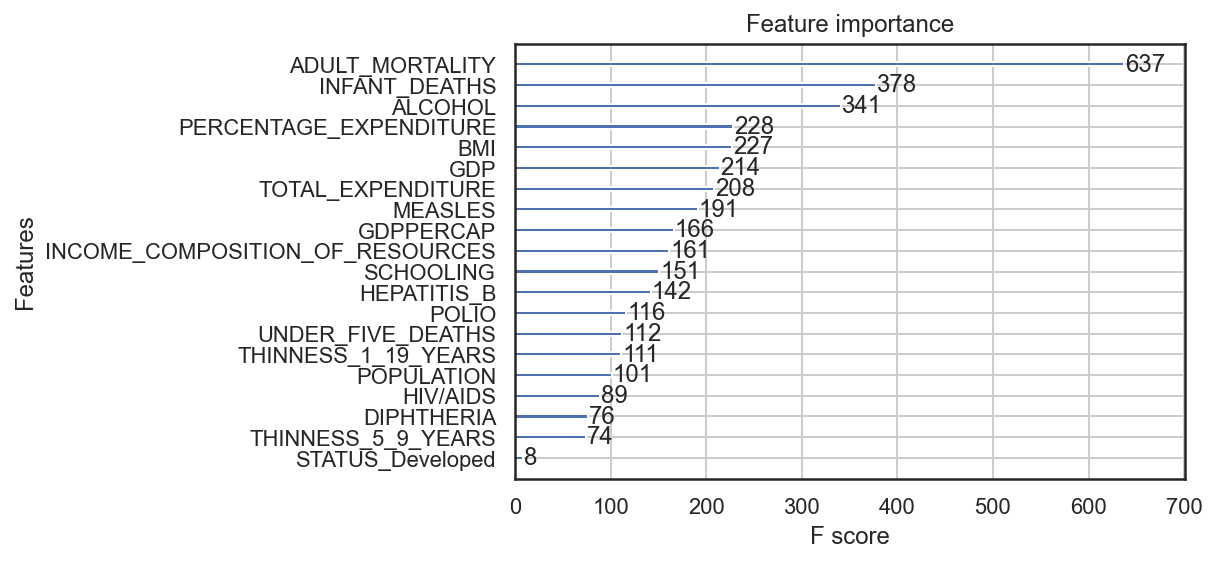

In [68]:
def xgb_regressor(data):
    original = add_feature(data, "gdppercap")
    original["GDPPERCAP"].fillna(original["GDP"] / original["POPULATION"], inplace=True)

    X, y = original_sortion_xy(original)   
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)

    model = XGBRegressor()
    model.fit(X_train, y_train, eval_metric="error", verbose=True)
    
    pred_test = model.predict(X_test)
    predictions = [round(value) for value in pred_test]

    # evaluate predictions
    r2 = model.score(X_test, y_test)
    print("R-squared :", r2)
    
    rmse_tr = np.sqrt(mean_squared_error(y_tuple[0], pred_tuple[0]))
    rmse_test = np.sqrt(mean_squared_error(y_tuple[1], pred_tuple[1]))
    
    print('XGB RMSE of train data:', rmse_tr)
    print('XGB RMSE of test data:', rmse_test)
    
    lm = sm.OLS(y_test, X_test).fit()
    print('\n', lm.summary())
    
    return model

model = xgb_regressor(original)
plot_importance(model)
plt.show()

In [70]:
# xgboost cross validation
def xgb_cv(data, n_splits=5):
    original = add_feature(data, "gdppercap")
    original["GDPPERCAP"].fillna(original["GDP"] / original["POPULATION"], inplace=True)

    X, y = original_sortion_xy(data)
    kfold = KFold(n_splits=5, shuffle=True, random_state=13)
    model = XGBRegressor()

    accuracy = cross_val_score(model, X, y, cv=kfold)
    print('Cross Validation : ', accuracy)
    print('Cross Validation Mean :', accuracy.mean())
    print('Cross Validation std :', accuracy.std())
    
    rmse_tr = np.sqrt(mean_squared_error(y_tuple[0], pred_tuple[0]))
    rmse_test = np.sqrt(mean_squared_error(y_tuple[1], pred_tuple[1]))
    
    print('XGB RMSE of train data:', rmse_tr)
    print('XGB RMSE of test data:', rmse_test)
    
    lm = sm.OLS(y_test, X_test).fit()
    print('\n', lm.summary())

xgb_cv(original)

Cross Validation :  [0.97247119 0.96608559 0.96086203 0.96954801 0.9634719 ]
Cross Validation Mean : 0.9664877453761834
Cross Validation std : 0.004149039315369712
XGB RMSE of train data: 2.807310820722564
XGB RMSE of test data: 2.7228041076998832

                             OLS Regression Results                            
Dep. Variable:        LIFE_EXPECTANCY   R-squared:                       0.920
Model:                            OLS   Adj. R-squared:                  0.917
Method:                 Least Squares   F-statistic:                     337.6
Date:                Sat, 15 May 2021   Prob (F-statistic):          6.03e-292
Time:                        22:14:36   Log-Likelihood:                -1394.7
No. Observations:                 580   AIC:                             2829.
Df Residuals:                     560   BIC:                             2917.
Df Model:                          19                                         
Covariance Type:            nonrobust  

#### 4. Random Forest Regressor
- $R^2$ 97.3 (Linear Regression 대비 +5.3)
- cross validation mean: 97.0%
- RMSE 2.72

In [71]:
# RandomForest Regressor 
def rf_regressor(data):
    original = add_feature(data, filename="gdppercap")
    original["GDPPERCAP"].fillna(data["GDP"] / original["POPULATION"], inplace=True)

    X, y = original_sortion_xy(original)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)
    
    model = RandomForestRegressor()
    model.fit(X_train, y_train)
    
    print("Random Forest Regressor R-squared :", model.score(X_test, y_test))
    
    rmse_tr = np.sqrt(mean_squared_error(y_tuple[0], pred_tuple[0]))
    rmse_test = np.sqrt(mean_squared_error(y_tuple[1], pred_tuple[1]))
    
    print('Random Forest Regressor RMSE of train data:', rmse_tr)
    print('Random Forest Regressor RMSE of test data:', rmse_test)

    lm = sm.OLS(y_test, X_test).fit()
    print(lm.summary(), '\n')

    return X_test, y_test

rf_regressor(original)

Random Forest Regressor R-squared : 0.9732053489679762
Random Forest Regressor RMSE of train data: 2.807310820722564
Random Forest Regressor RMSE of test data: 2.7228041076998832
                            OLS Regression Results                            
Dep. Variable:        LIFE_EXPECTANCY   R-squared:                       0.923
Model:                            OLS   Adj. R-squared:                  0.920
Method:                 Least Squares   F-statistic:                     335.1
Date:                Sat, 15 May 2021   Prob (F-statistic):          9.62e-296
Time:                        22:15:04   Log-Likelihood:                -1382.5
No. Observations:                 580   AIC:                             2807.
Df Residuals:                     559   BIC:                             2899.
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                               

(      ADULT_MORTALITY  INFANT_DEATHS  ALCOHOL  PERCENTAGE_EXPENDITURE  \
 2892              429           47.9     6.09                    6.92   
 2312              441          114.5     3.91                    9.87   
 1691               67           11.2     1.92                    7.92   
 784               171           37.2     0.14                    4.92   
 435                51          108.5     1.49                    4.23   
 ...               ...            ...      ...                     ...   
 280               167           13.9    10.15                    4.86   
 378                16           13.8     8.41                    6.77   
 2592              158           15.5     1.24                    2.93   
 723                11            4.5    11.54                    8.90   
 273               189           14.0    11.64                    3.92   
 
       HEPATITIS_B  MEASLES   BMI  UNDER_FIVE_DEATHS  POLIO  TOTAL_EXPENDITURE  \
 2892         97.0        0 

In [72]:
# RandomForest Regressor cross validation
def rf_regressor_cv(data, n_splits=5):
    original = add_feature(data, "gdppercap")
    original["GDPPERCAP"].fillna(original["GDP"] / original["POPULATION"], inplace=True)

    X, y = original_sortion_xy(data)
    kfold = KFold(n_splits=5, shuffle=True, random_state=13)
    model = RandomForestRegressor()

    accuracy = cross_val_score(model, X, y, cv=kfold)
    print('Cross Validation : ', accuracy)
    print('Cross Validation Mean :', accuracy.mean())
    print('Cross Validation std :', accuracy.std())

    rmse_tr = np.sqrt(mean_squared_error(y_tuple[0], pred_tuple[0]))
    rmse_test = np.sqrt(mean_squared_error(y_tuple[1], pred_tuple[1]))
    
    print('Random Forest Regressor RMSE of train data:', rmse_tr)
    print('Random Forest Regressor RMSE of test data:', rmse_test)

rf_regressor_cv(original)

Cross Validation :  [0.97307724 0.96974432 0.96468487 0.97491821 0.97025977]
Cross Validation Mean : 0.9705368824384999
Cross Validation std : 0.003481394348969584
Random Forest Regressor RMSE of train data: 2.807310820722564
Random Forest Regressor RMSE of test data: 2.7228041076998832


Random Forest Regressor R-squared : 0.9731231984900556
Random Forest Regressor RMSE :  0.9864700697385884
                            OLS Regression Results                            
Dep. Variable:        LIFE_EXPECTANCY   R-squared:                       0.923
Model:                            OLS   Adj. R-squared:                  0.920
Method:                 Least Squares   F-statistic:                     335.1
Date:                Sat, 15 May 2021   Prob (F-statistic):          9.62e-296
Time:                        21:54:36   Log-Likelihood:                -1382.5
No. Observations:                 580   AIC:                             2807.
Df Residuals:                     559   BIC:                             2899.
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
----

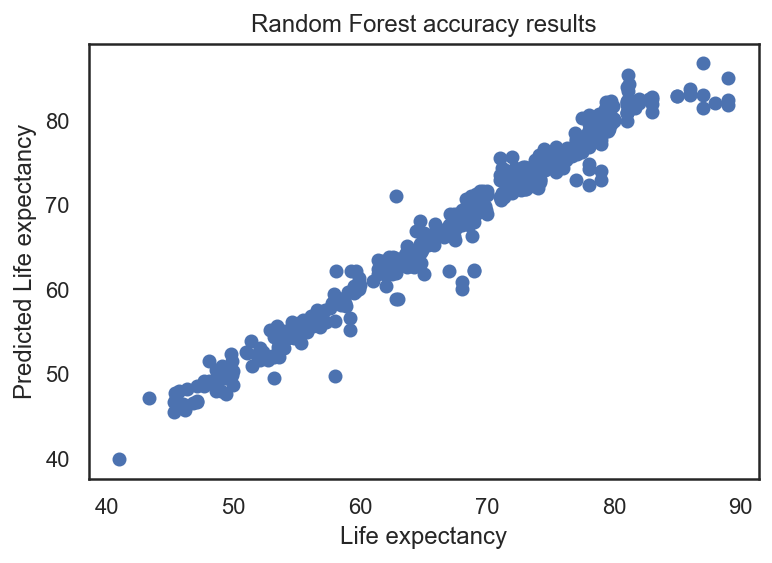

In [33]:
X_test, y_test = rf_regressor(original)
y_pred = model.predict(X_test)

plt.scatter(y_test, y_pred)
plt.xlabel("Life expectancy")
plt.ylabel("Predicted Life expectancy")

plt.title("Random Forest accuracy results");

### Linear Regression model predict
- Linear Regression

In [81]:
def get_settings(original):
    data = preprocessing(original)
    top_features = get_top_features(data, drop_n=5)
    fence = get_fence(data, top_features)
    data = drop_outlier(data, fence, top_features)
    data = data.drop(['COUNTRYCODE', 'ISO3166', 'YEAR', 'INCOMEGROUP'], axis=1)
    
    return data

In [107]:
original = pd.read_csv("../datas/life_expectancy_data_fillna.csv")

def model_pred(model, pred_data):
    data = get_settings(original)
    top_features = get_top_features(original)

    X = data[top_features]
    y = data['LIFE_EXPECTANCY']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=13)
    model = model
    model.fit(X_train, y_train)

    y_pred = model.predict(pred_data)
    
    return y_pred

In [109]:
# Sample data
korea = data[data['COUNTRY'] == 'Korea, Rep.'][-1:]
pred_kor = korea[top_features]

model_pred(LinearRegression(), pred_kor)

array([80.89506046])

### Feature Extraction
#### 1. PCA
   - based on REGION
       - scree plot
       - biplot
       - PCA1 score<br><br>
   - based on COUNTRY
       - PCA1 score

In [77]:
# data processing
original = pd.read_csv("../datas/life_expectancy_data_fillna.csv")

data = get_settings(original)

In [35]:
# standard scaler
def fit_scaler(data):
    original_ss = StandardScaler().fit_transform(data)
    ss_df = pd.DataFrame(original_ss, index=data.index, columns=data.columns)
    
    return ss_df

In [36]:
def fit_pca(data, n_component=2):
    # standard scaler
    ss_df = fit_scaler(data)
    
    pca = PCA(n_components=n_component)
    pca_res = pca.fit_transform(ss_df)
    pc_values = np.arange(pca.n_components_) + 1
    pca_var = pca.explained_variance_ratio_
    
    # 각 주성분 값을 데이터로 하는 데이터프레임을 생성한다. 
    pca_df = pd.DataFrame(pca_res, index=ss_df.index, 
                          columns=[f"pca{num+1}" for num in range(n_component)])
    
    return pca_df, pc_values, pca_var

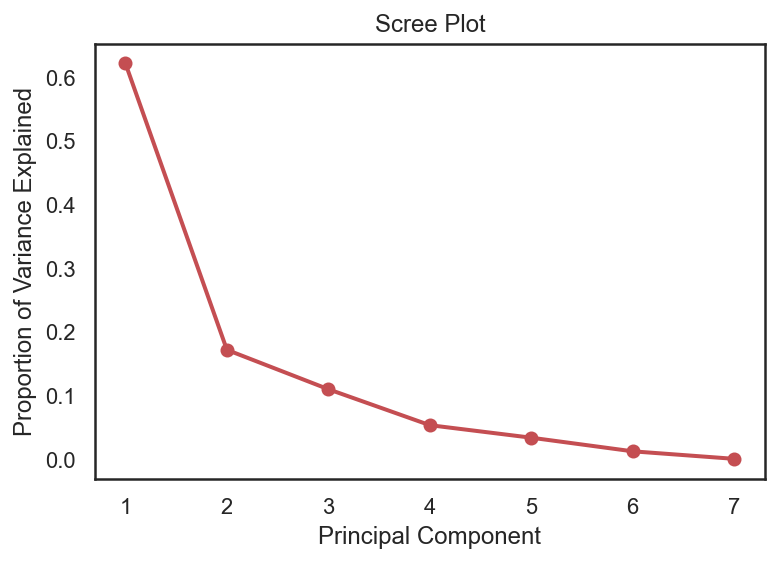

,pca1,pca2,pca3,pca4,pca5,pca6,pca7
REGION,,,,,,,
East Asia & Pacific,-1.175295,-1.143638,0.886127,2.259899,0.359853,-0.173309,1.654269e-16
Europe & Central Asia,3.529558,-0.315325,-0.565568,-0.738011,1.664536,-0.179632,1.654269e-16
Latin America & Caribbean,0.688002,-1.337765,-1.254819,0.031671,-0.331972,1.036700,1.654269e-16
Middle East & North Africa,0.574242,-2.569218,-0.651985,-0.689380,-1.017976,-0.659631,1.654269e-16
North America,5.516511,2.727326,0.990658,0.204743,-0.769338,-0.014324,1.654269e-16
South Asia,-4.241071,0.041874,2.648707,-1.111723,0.106182,0.194996,1.654269e-16
Sub-Saharan Africa,-4.891947,2.596746,-2.053121,0.042802,-0.011285,-0.204802,1.654269e-16


In [37]:
# pca scree plot
def show_screeplot(data, n_component=2):    
    target = data['LIFE_EXPECTANCY']
    data = data.drop(['LIFE_EXPECTANCY'], axis=1)
    
    # fit pca
    pca_df, pc_values, pca_var = fit_pca(data, n_component)
    
    
    # explained_variance_ration (pca_var): 주성분 벡터를 이용해 투영한 후 분산의 비율
    plt.plot(pc_values, pca_var, 'ro-', linewidth=2)
    plt.title('Scree Plot')
    plt.xlabel('Principal Component') # 주성분 개수
    plt.ylabel('Proportion of Variance Explained') # 고유값 (분산 값)

    plt.show()
    
    return pca_df

# n_componenet : region num
data = data.groupby('REGION').mean().round(3)
n_component = len(data.index)
show_screeplot(data, n_component)

[pca] >Processing dataframe..
[pca] >The PCA reduction is performed on the [20] columns of the input dataframe.
[pca] >Fitting using PCA..
[pca] >Computing loadings and PCs..
[pca] >Computing explained variance..
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[2]
[pca] >Outlier detection using SPE/DmodX with n_std=[2]


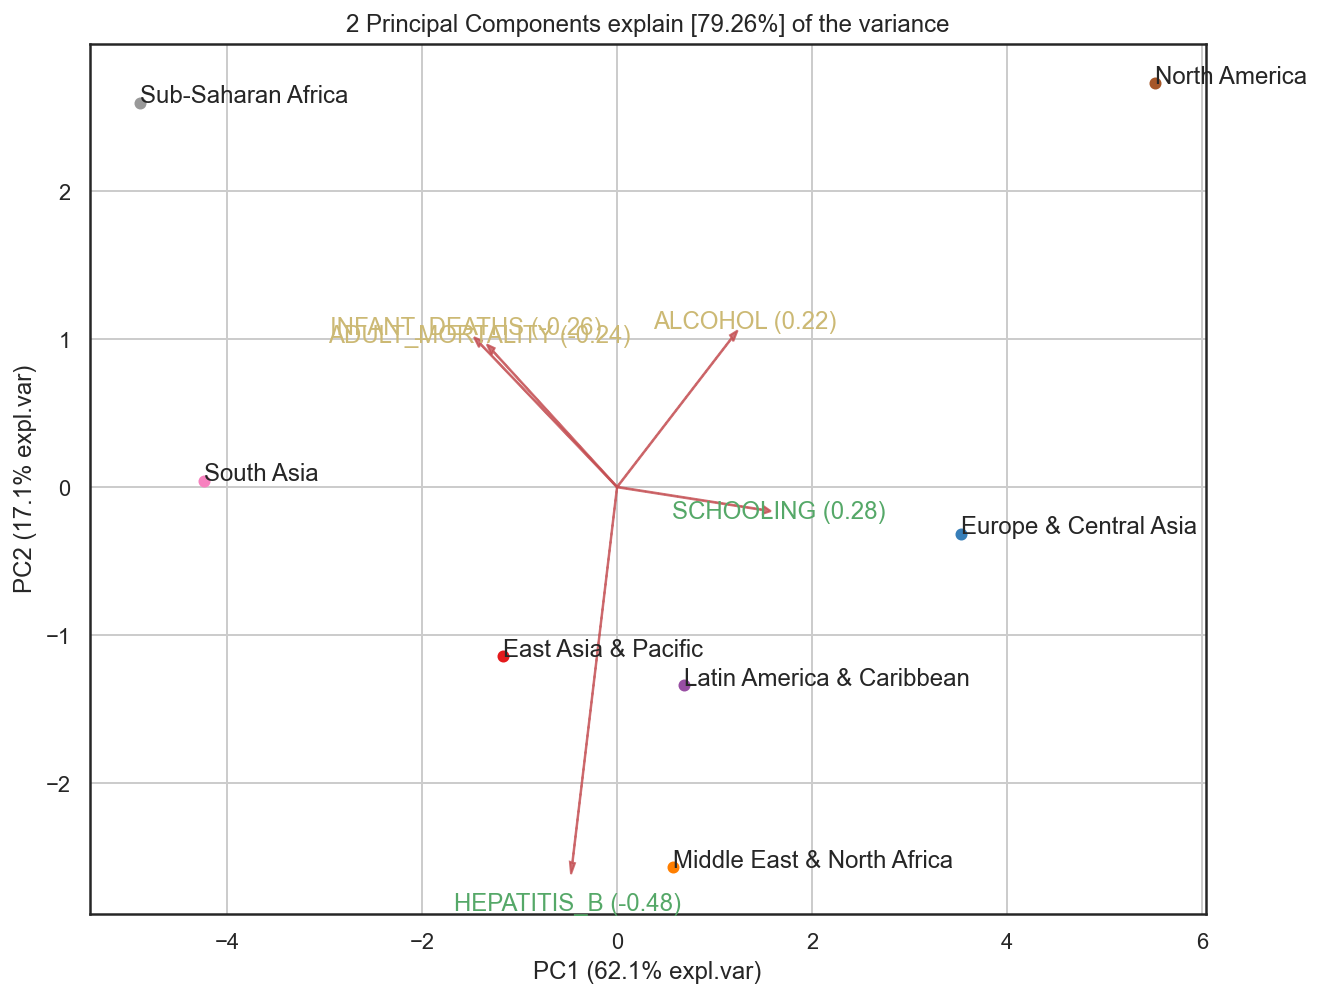

In [38]:
from pca import pca 

def show_biplot(data, n_component=2, feature_num=5):
    data = data.drop(['LIFE_EXPECTANCY'], axis=1)
    
    model = pca(n_components=n_component)
    # fit scaler
    ss_df = fit_scaler(data)
    # pca
    results = model.fit_transform(ss_df)
    fig, ax = model.biplot(n_feat=feature_num, legend=False)
    
n_component = 2
feature_num = 5 # 표시할 주요 feature 개수
show_biplot(data, n_component, feature_num)

In [39]:
# 1주성분을 기준으로 리전 / 나라를 정렬했을 때 1주성분 벡터값이 가장 높은 리전 / 나라
def sortion_pca1(n_component=7):
    pca_df, pc_values, pca_var = fit_pca(data, n_component)

    pca_1 = pca_df[['pca1']]
    pca_1 = pca_1.sort_values(by='pca1', ascending=False)
    pca_1 = pca_1.reset_index()

    pca_1.index = pca_1.index+1
    pca_1.index.name = 'Ranking'

    return pca_1

In [40]:
# region ranking

original = pd.read_csv("../datas/life_expectancy_data_fillna.csv")
# data processing
data = get_settings(original)

# n_componenet : region num
data = data.groupby('REGION').mean().round(3)
n_component = len(data.index)
pca1_df = pd.DataFrame(sortion_pca1(n_component))
pca1_df

,REGION,pca1
Ranking,,
1,North America,5.612718
2,Europe & Central Asia,3.618881
3,Latin America & Caribbean,0.754513
4,Middle East & North Africa,0.682468
5,East Asia & Pacific,-1.141534
6,South Asia,-4.211944
7,Sub-Saharan Africa,-5.315102


In [41]:
# country ranking

original = pd.read_csv("../datas/life_expectancy_data_fillna.csv")
# data processing
data = get_settings(original)

# n_componenet : country num
data = data.groupby('COUNTRY').mean().round(3)
n_component = len(data.index)
pca1_df = pd.DataFrame(sortion_pca1())
pca1_df

,COUNTRY,pca1
Ranking,,
1,United States,6.415500
2,Norway,4.872999
3,Luxembourg,4.805138
4,Sweden,4.770428
5,Switzerland,4.760539
...,...,...
172,Nigeria,-5.432439
173,India,-5.633823
174,Chad,-5.908881
